# Computer Assignment 2 

This is an all-in-one report to 6123 IVP, where the explanations, discussions and codes are included.

All experiments are run in Python code.

Import the libs we need.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

from matplotlib import rcParams
from matplotlib import rc
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.special import comb
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
pi = np.pi
%matplotlib inline

## 1. 2D Convolution

Define `conv2D` function.

It receives a single-channel or multi-channel `uint8` image, and does 2D convolution using the given kernel over all channels.

In [2]:
def conv2D(img,kernel):
    k,l = np.shape(kernel)
    if img.ndim == 2: # ex.gray scale
        m,n = np.shape(img) 
        c = 1
        img = img[:,:,None]
    elif img.ndim == 3:
        m,n,c = np.shape(img)
    
    img_c = np.zeros([m+k-1,n+l-1,c])
    img_ex = np.zeros([m+2*k-2,n+2*l-2,c])
    img_ex[k-1:k+m-1,l-1:l+n-1,:] = img.astype('float')
    kernel = np.ones([k,l,c]) * kernel[:,:,None]
    for mc in range(m+k-1):
        for nc in range(n+l-1):
            img_c[mc,nc,:] = np.sum(np.sum(img_ex[mc:mc+k,nc:nc+l,:] * kernel,0),0)
    img_max = np.max(np.max(img_c,0),0)
    img_min = np.min(np.min(img_c,0),0)
    img_c = (img_c - img_min[None,None,:]) * 255 / (img_max[None,None,:] - img_min[None,None,:] + 1e-8)
    img_c = np.round(img_c)
    
    if c == 1:
        img_c = np.reshape(img_c,[m+k-1,n+l-1])
    return img_c.astype('uint8')

Define `main` function

In [3]:
def main(filename,kernel):
    img = cv2.imread(filename)
    if img.ndim == 3:
        img = (np.sum(img,2) / 3)#.astype('uint8')
        
    plt.figure(dpi=300,figsize=[10,12])
    plt.subplot(321)
    plt.imshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title('Original Image')
    
    img_fil = conv2D(img,kernel)
    img_fft = np.fft.fft2(img)
    img_fil_fft = np.fft.fft2(img_fil)
    kernel_fft = np.fft.fft2(kernel, s=np.shape(img))
    
    plt.subplot(322)
    plt.imshow(img_fil,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title('Filtered Image')
    
    plt.subplot(323)
    plt.imshow(np.log(np.abs(np.fft.fftshift(img_fft))),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title('Mag of FFT of Original Image')
    
    plt.subplot(324)
    plt.imshow(np.log(np.abs(np.fft.fftshift(img_fil_fft))),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title('Mag of FFT of Filtered Image')
    
    plt.subplot(325)
    plt.imshow((np.abs(np.fft.fftshift(kernel_fft))),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title('Freq Response of Filter')
    
    plt.tight_layout()

Define three different kernels, they are:

$${{H}_{1}}=\frac{1}{16}\left( \begin{matrix}
   1 & 2 & 1  \\
   2 & 4 & 2  \\
   1 & 2 & 1  \\
\end{matrix} \right),{{H}_{2}}=\left( \begin{matrix}
   -1 & -1 & -1  \\
   -1 & 8 & -1  \\
   -1 & -1 & -1  \\
\end{matrix} \right),{{H}_{3}}=\left( \begin{matrix}
   0 & -1 & 0  \\
   -1 & 5 & -1  \\
   0 & -1 & 0  \\
\end{matrix} \right)$$


In [4]:
kernel1 = np.array([[1,2,1],[2,4,2],[1,2,1]])/16
kernel2 = np.array([[1,1,1],[1,-8,1],[1,1,1]])*(-1)
kernel3 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])

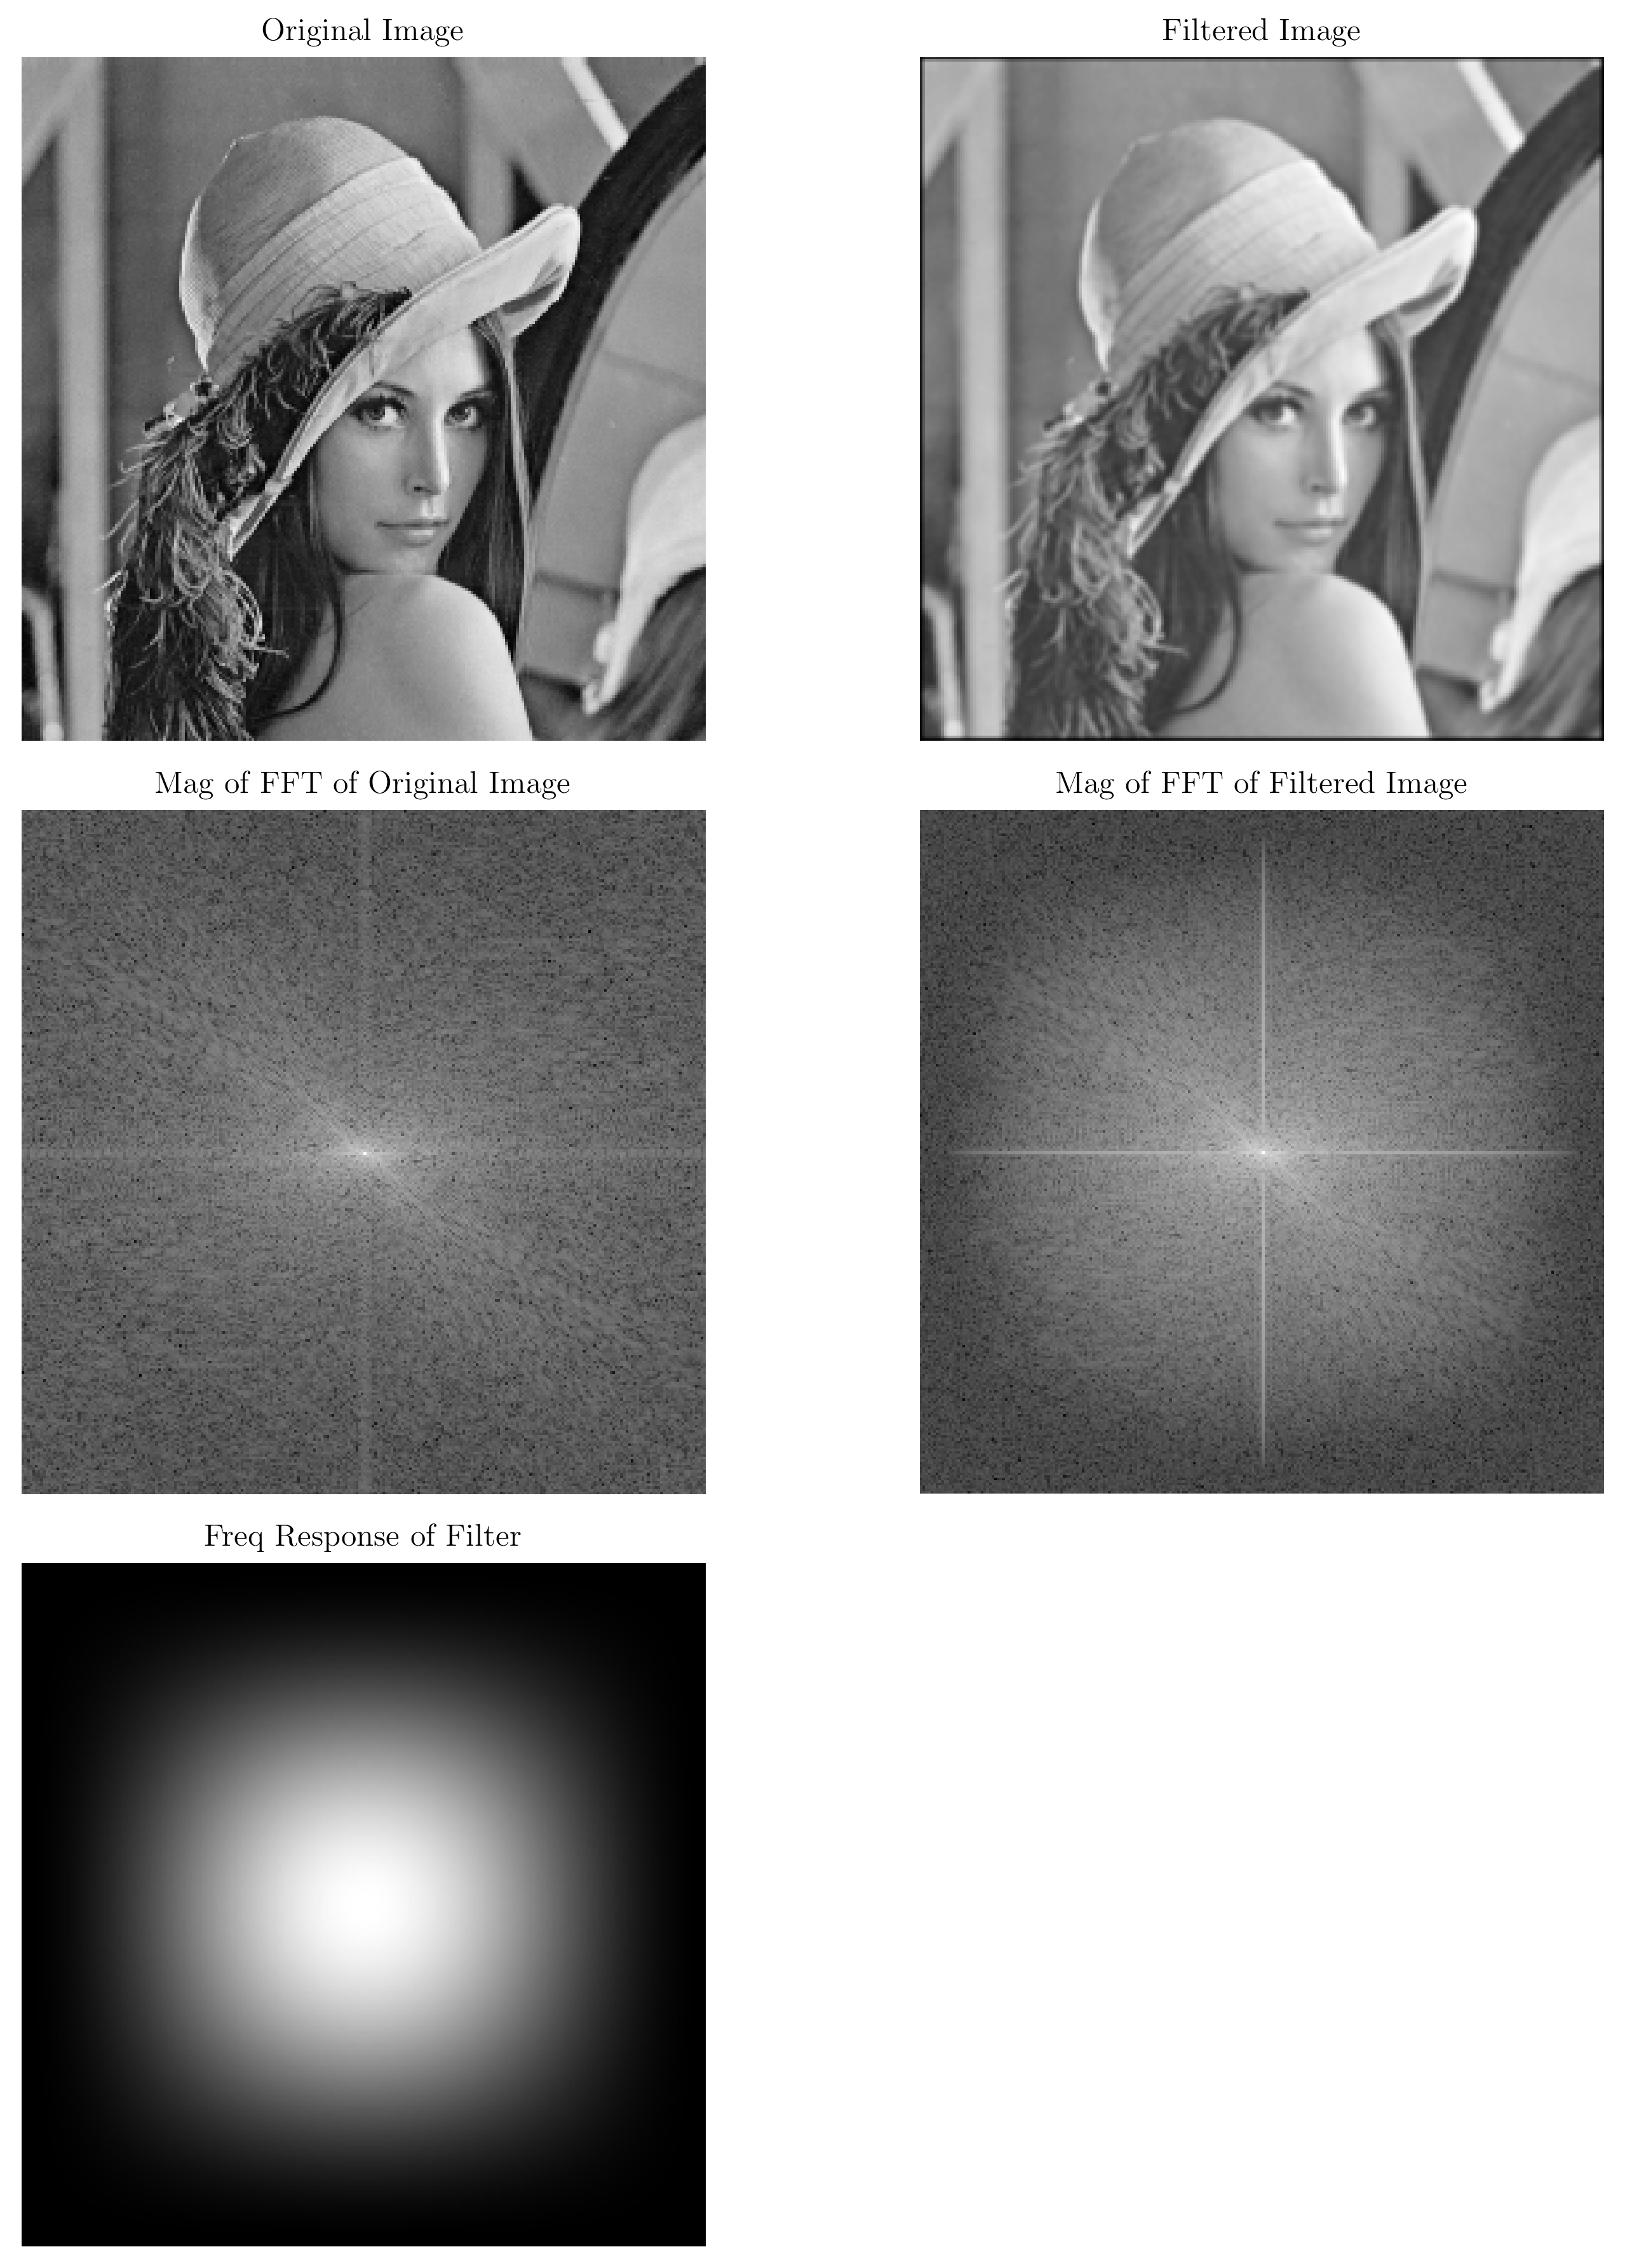

In [5]:
main('C:\\Users\\ZING\\Desktop\\6123\\CA\\Sol\\CA2\\lenna.jpg',kernel1)

The first filter is obviously a low-pass filter. We can see that compared to the original image, the filter image looks like smoothed and loses some high-frequency detail.

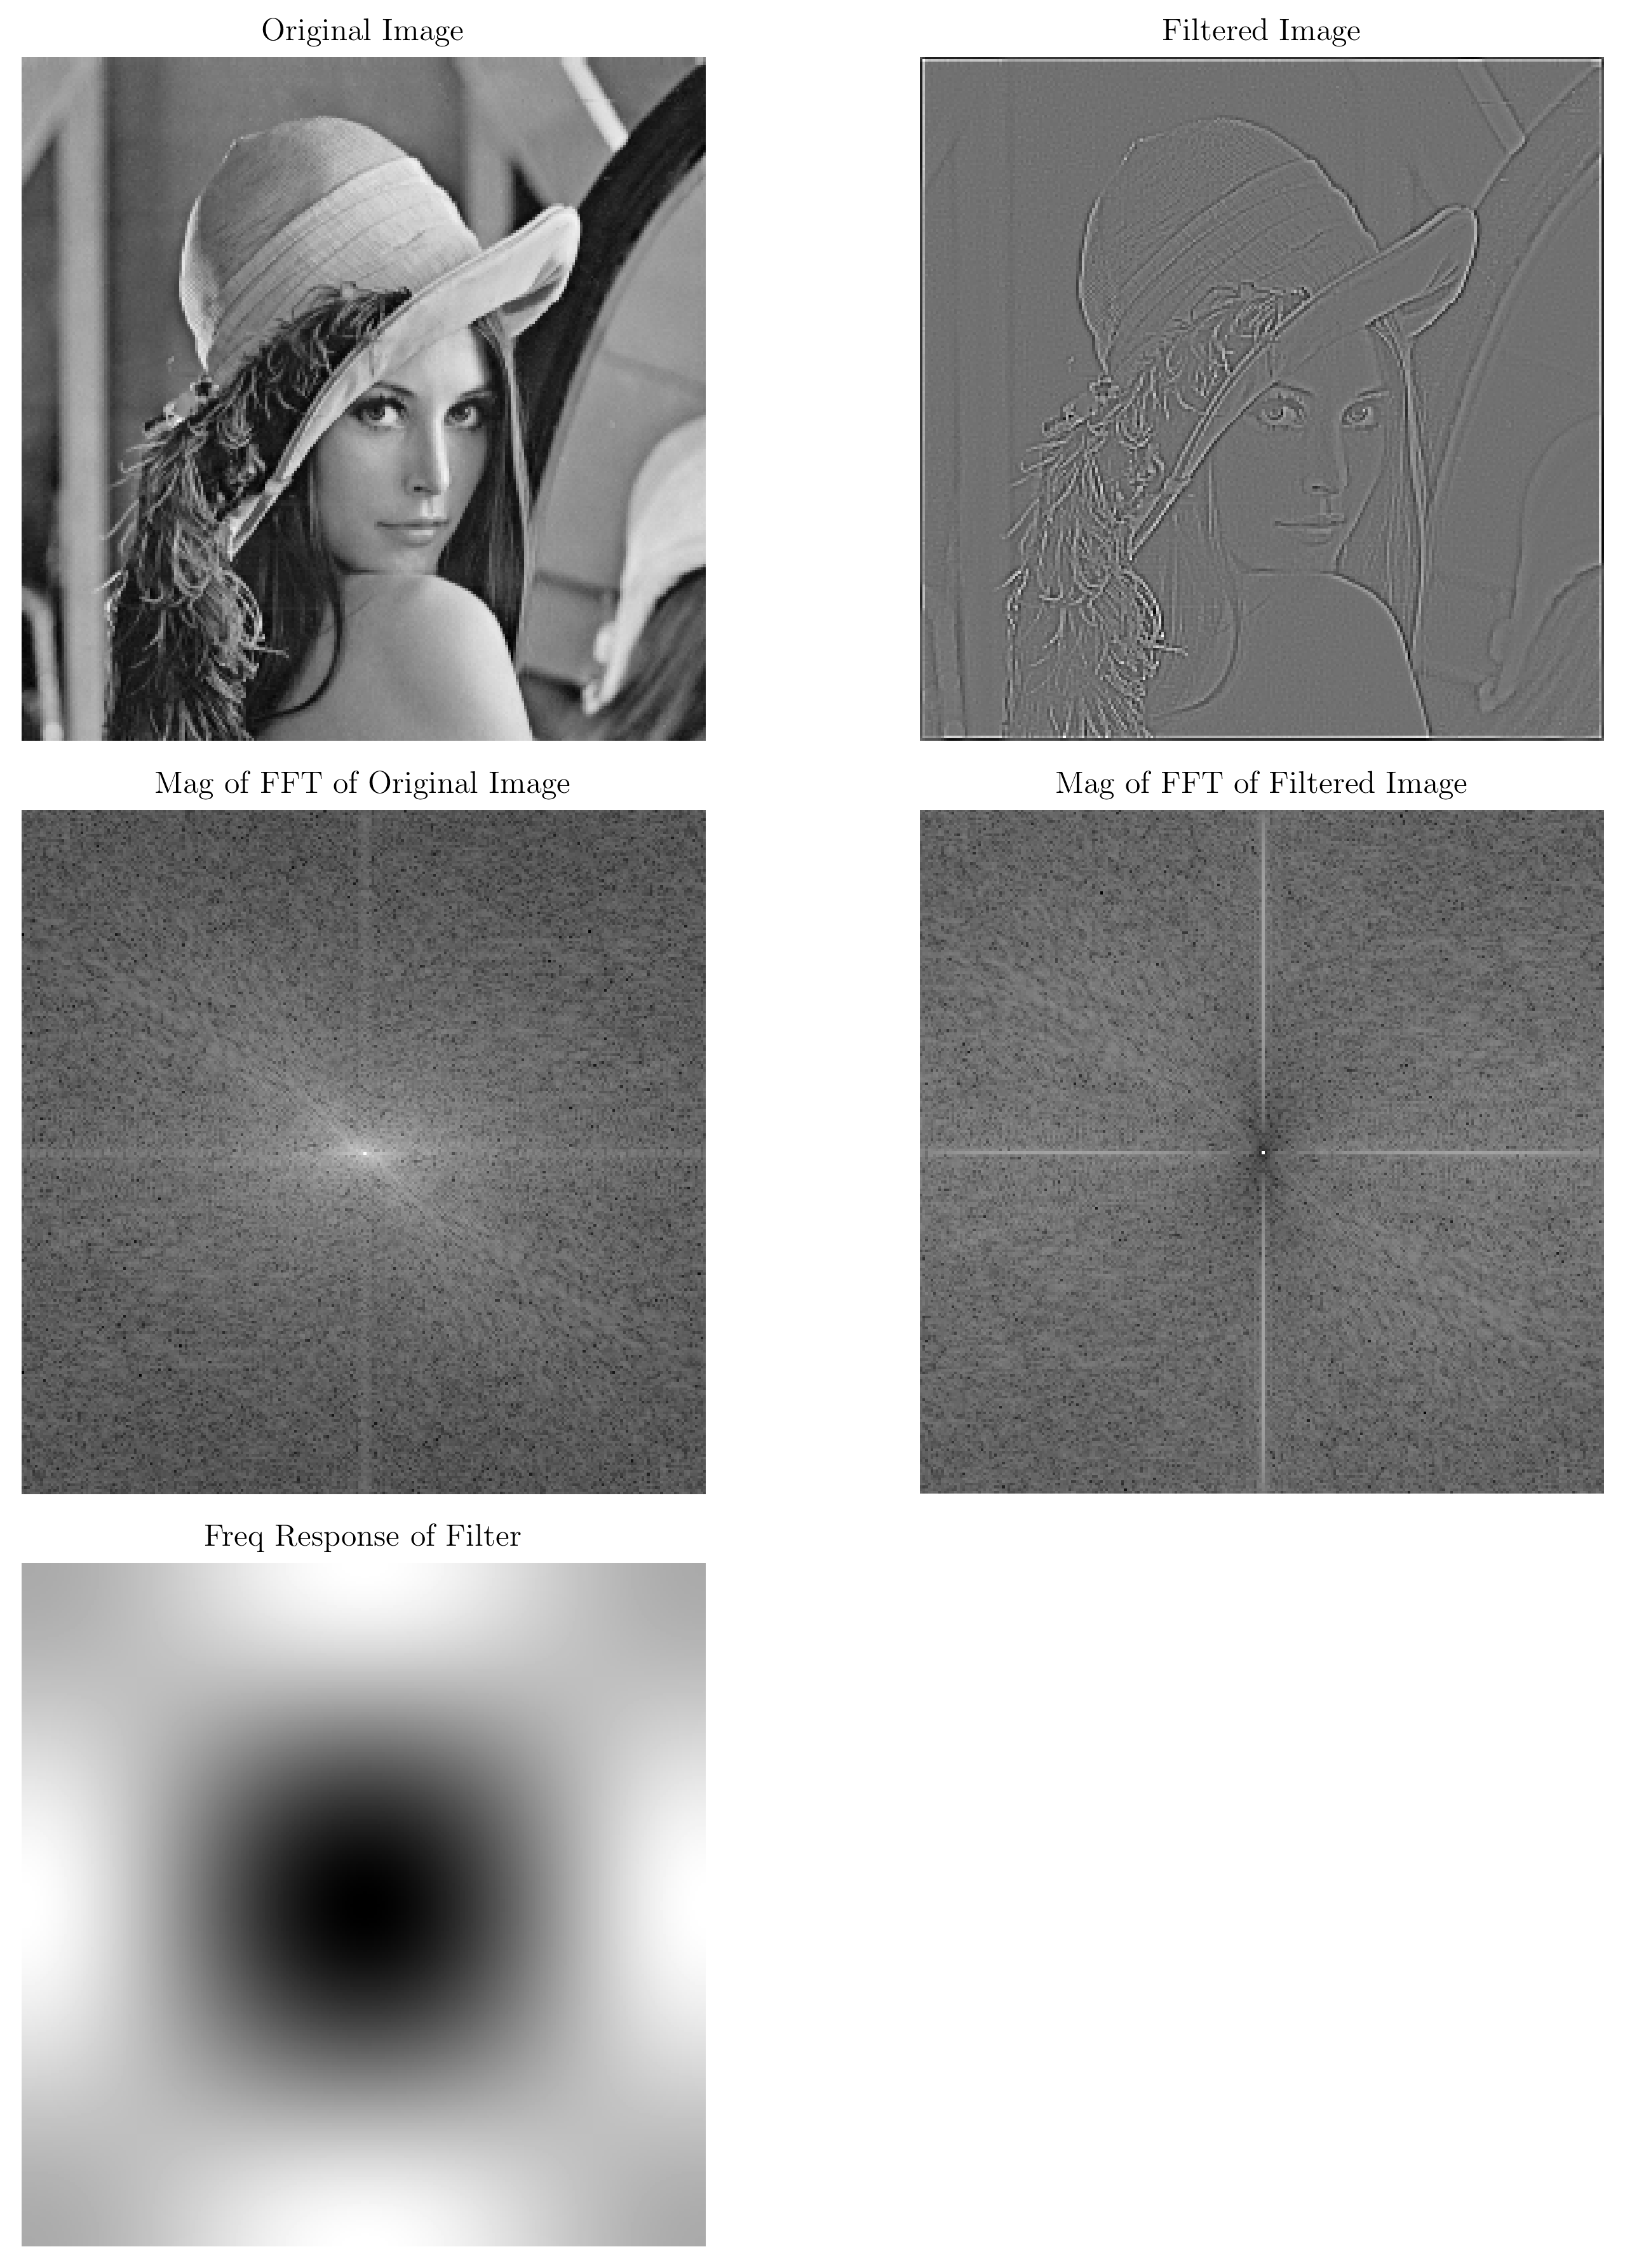

In [6]:
main('C:\\Users\\ZING\\Desktop\\6123\\CA\\Sol\\CA2\\lenna.jpg',kernel2)

The second filter is a Laplacian filter, more specifically, can be all-direction edge detector since its Fourier Transform is isotropic.

We see in filtered image most edges are identified.

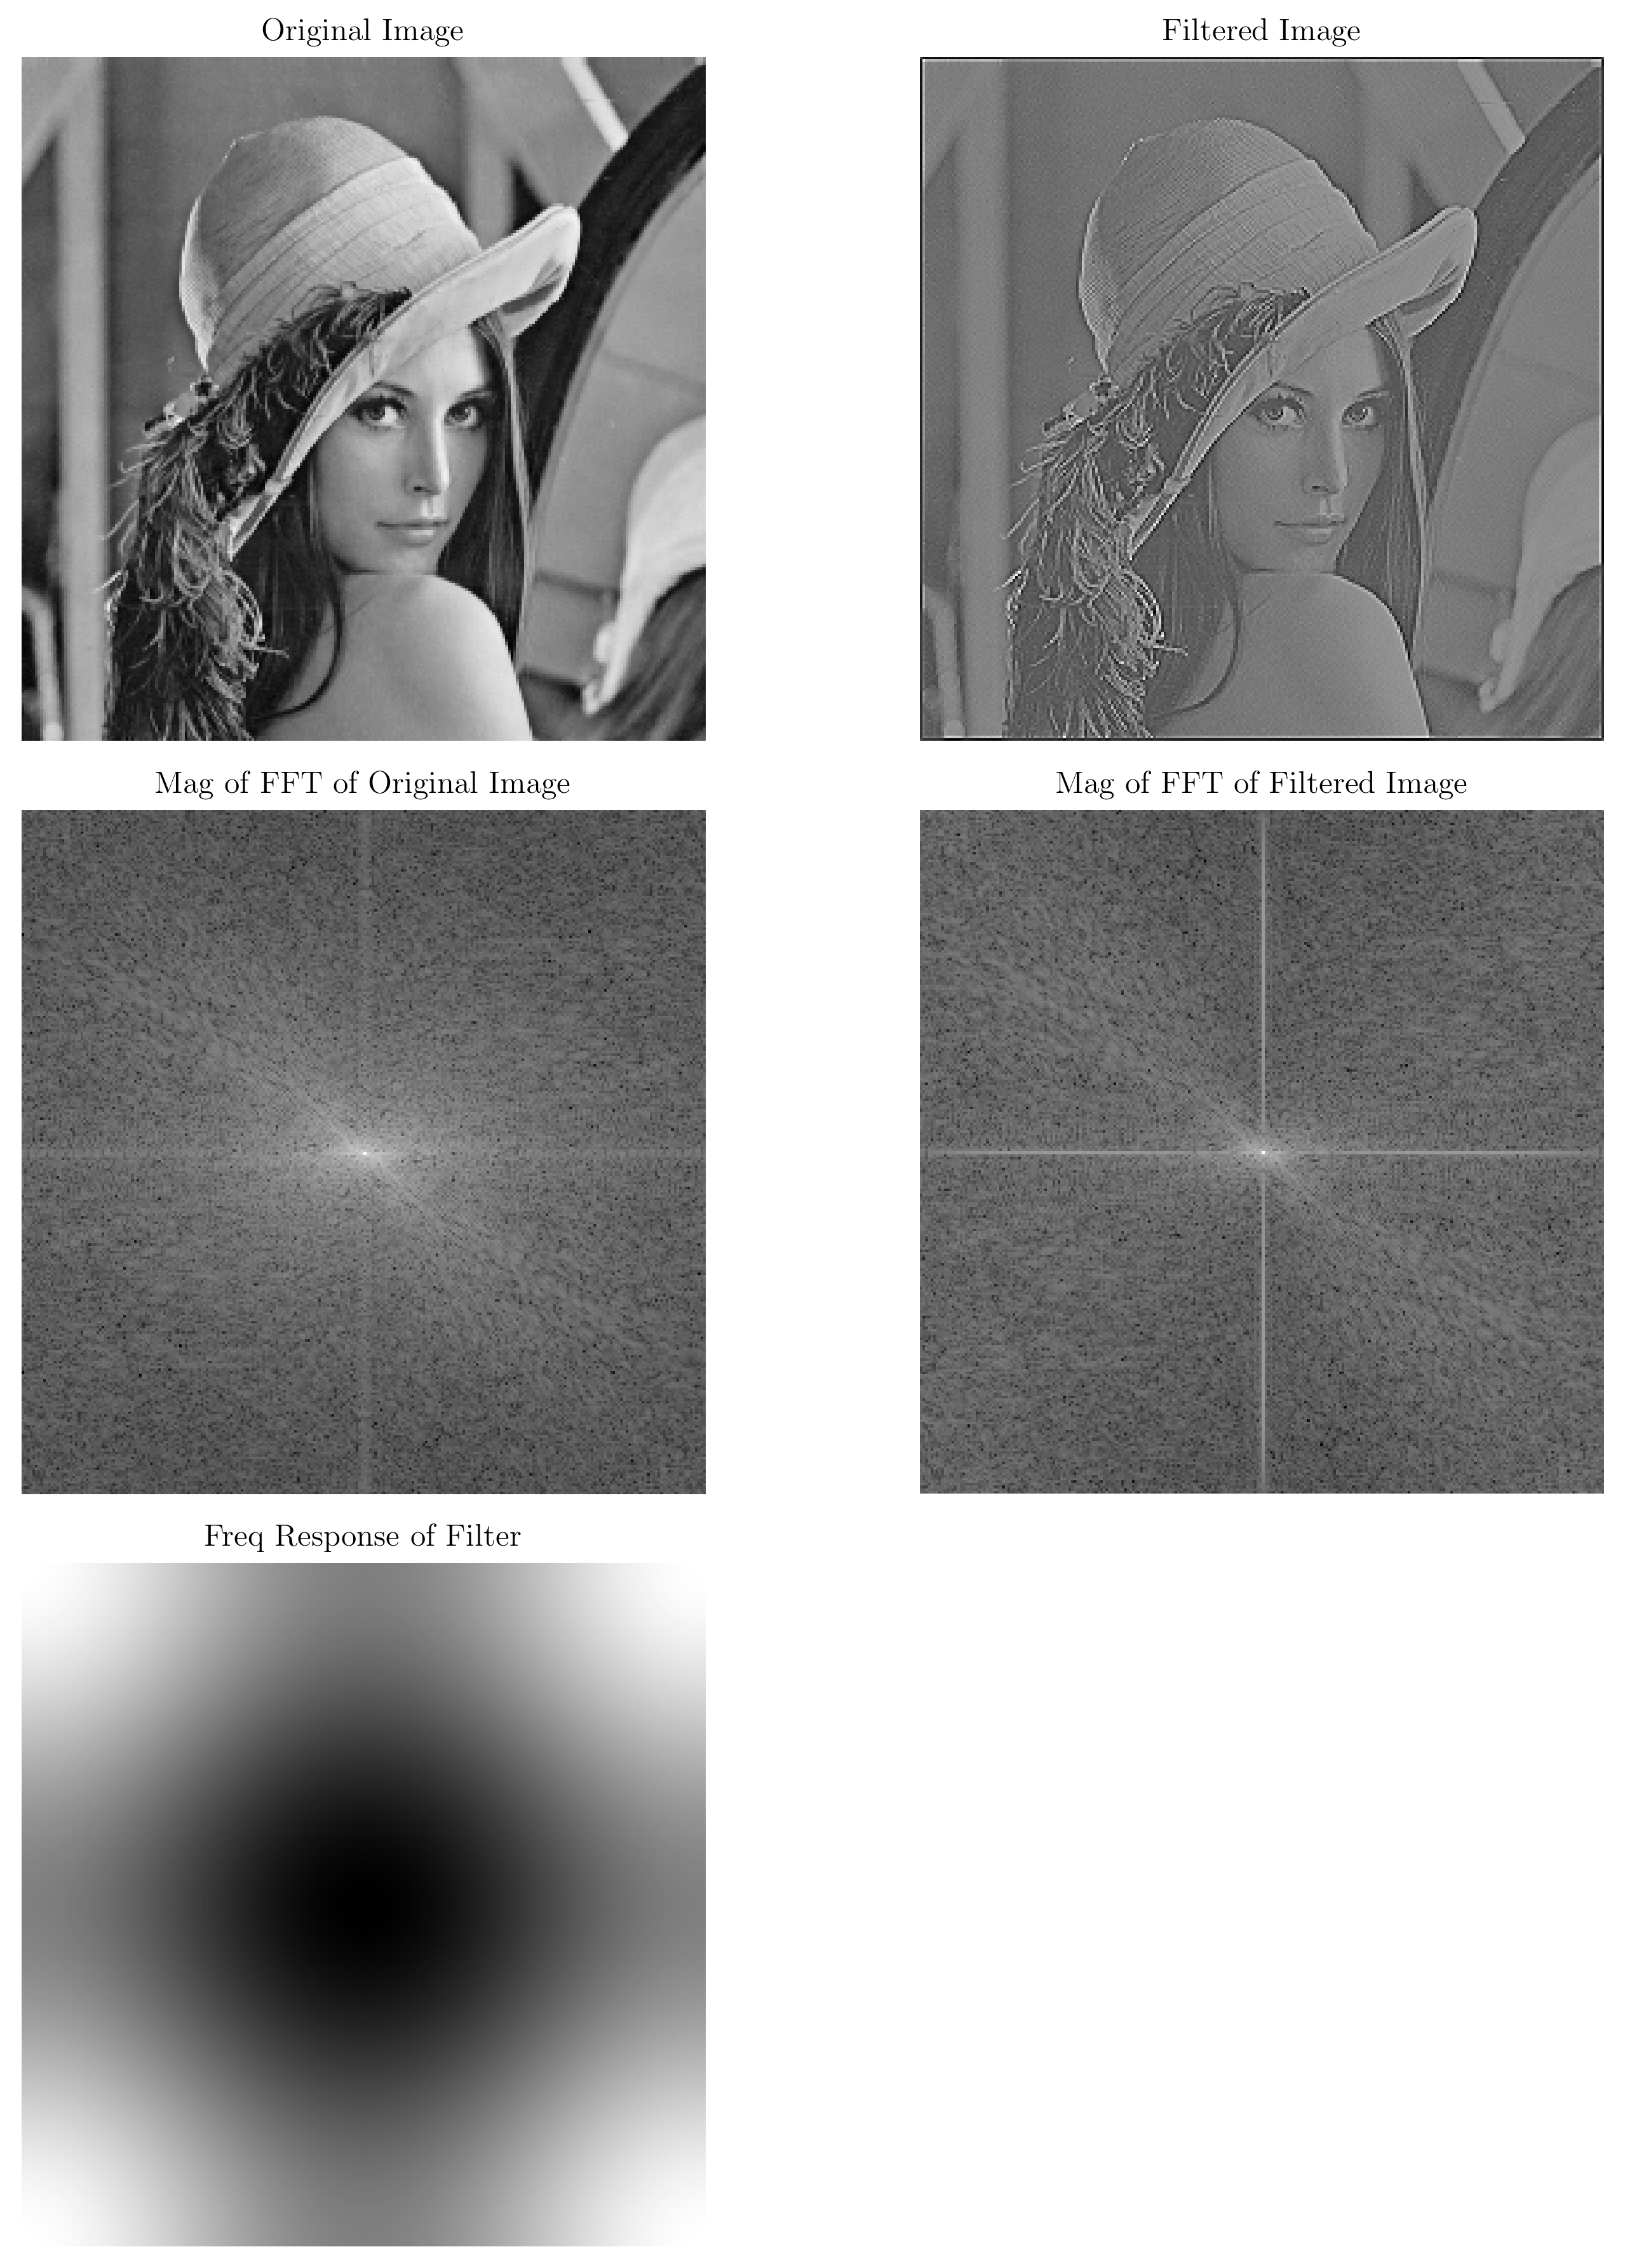

In [7]:
main('C:\\Users\\ZING\\Desktop\\6123\\CA\\Sol\\CA2\\lenna.jpg',kernel3)

The third filter is approximately a second-order derivative filter and therefore it performs some edge detection function but doesn't works very well.

## Noise Adding and Removal


Define `imnoise` function to add noise on images

In [8]:
def imnoise(img,mean,var):
    '''
    mean,var are appiled as if they are applied on a double image in range [0,1]
    '''
    mean = mean * 255
    var = var * 255
    img = img.astype('float') + np.random.normal(mean,var,np.shape(img))
    img[np.where(img>255)] = 255
    img[np.where(img<0)] = 0
    return img.astype('uint8')

Define average filters with `n=[5,7,9]` and gaussian filters with `n=[5,7,9]`

In [9]:
ave_filter = []
ave_filter.append(np.ones([5,5])/25)
ave_filter.append(np.ones([7,7])/49)
ave_filter.append(np.ones([9,9])/81)
ave_title = ['5','7','9']

gau_filter = []
gau_title = ['5','7','9']
x = np.exp(-np.linspace(-2,2,5)**2/2/1**2)[:,None]
gau_filter.append(np.dot(x,x.T) / np.sum(np.dot(x,x.T)))
x = np.exp(-np.linspace(-3,3,7)**2/2/1.4**2)[:,None]
gau_filter.append(np.dot(x,x.T) / np.sum(np.dot(x,x.T)))
x = np.exp(-np.linspace(-4,4,9)**2/2/1.8**2)[:,None]
gau_filter.append(np.dot(x,x.T) / np.sum(np.dot(x,x.T)))


Load image and add noise with `level=[0.01,0.1]`

In [11]:
lenna_gray = cv2.imread('C:\\Users\\ZING\\Desktop\\6123\\CA\\Sol\\CA2\\lenna.jpg',0)
lenna_gray_n = []
lenna_gray_n.append(imnoise(lenna_gray,0,0.01))
lenna_gray_n.append(imnoise(lenna_gray,0,0.1))
lgn_title = ['0.01','0.1']


Show gaussian-noised images

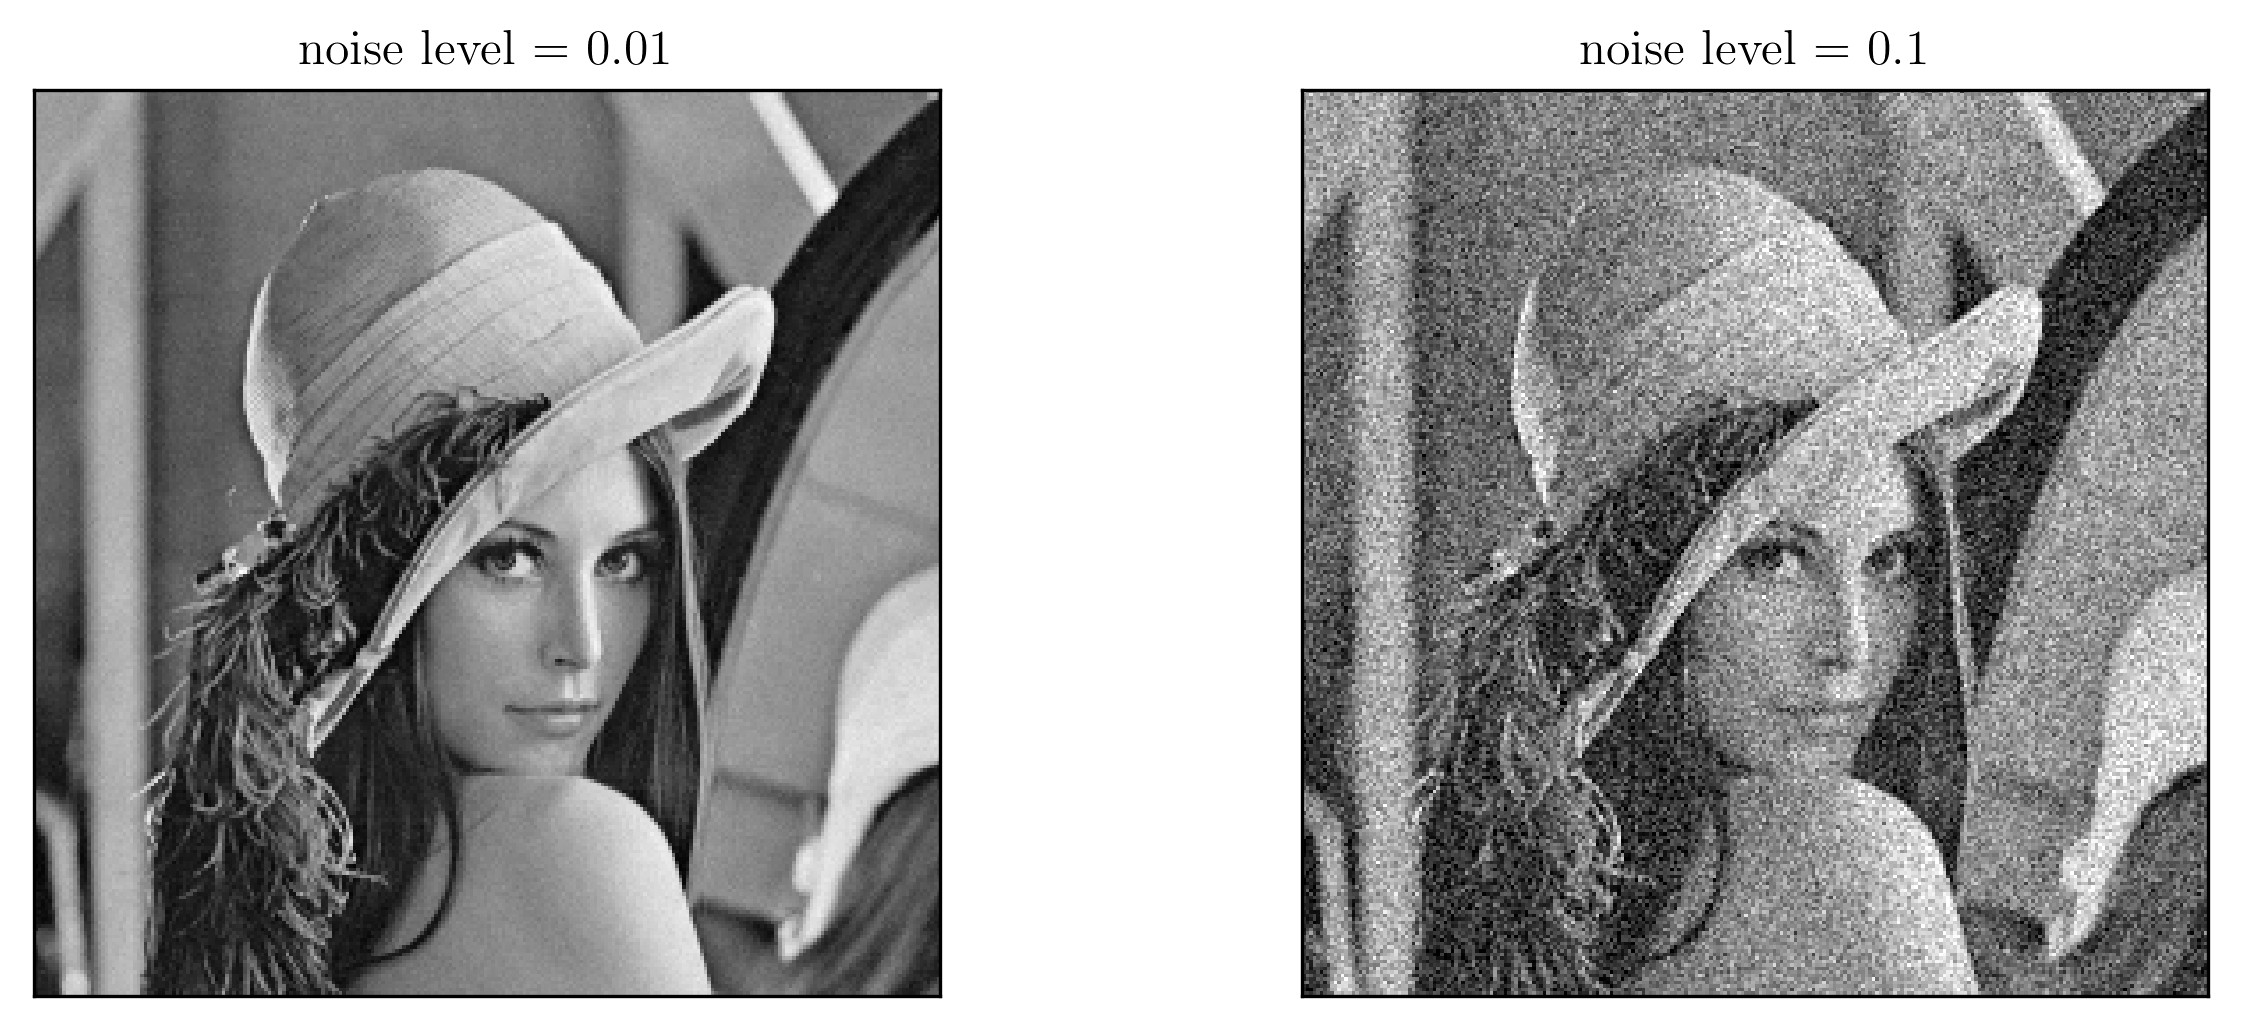

In [12]:
plt.figure(dpi = 300,figsize = (10,4))
for Id,im in enumerate(lenna_gray_n):
    plt.subplot(121+Id)
    plt.imshow(im,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('noise level = '+lgn_title[Id])

Begin to study the effect of filters

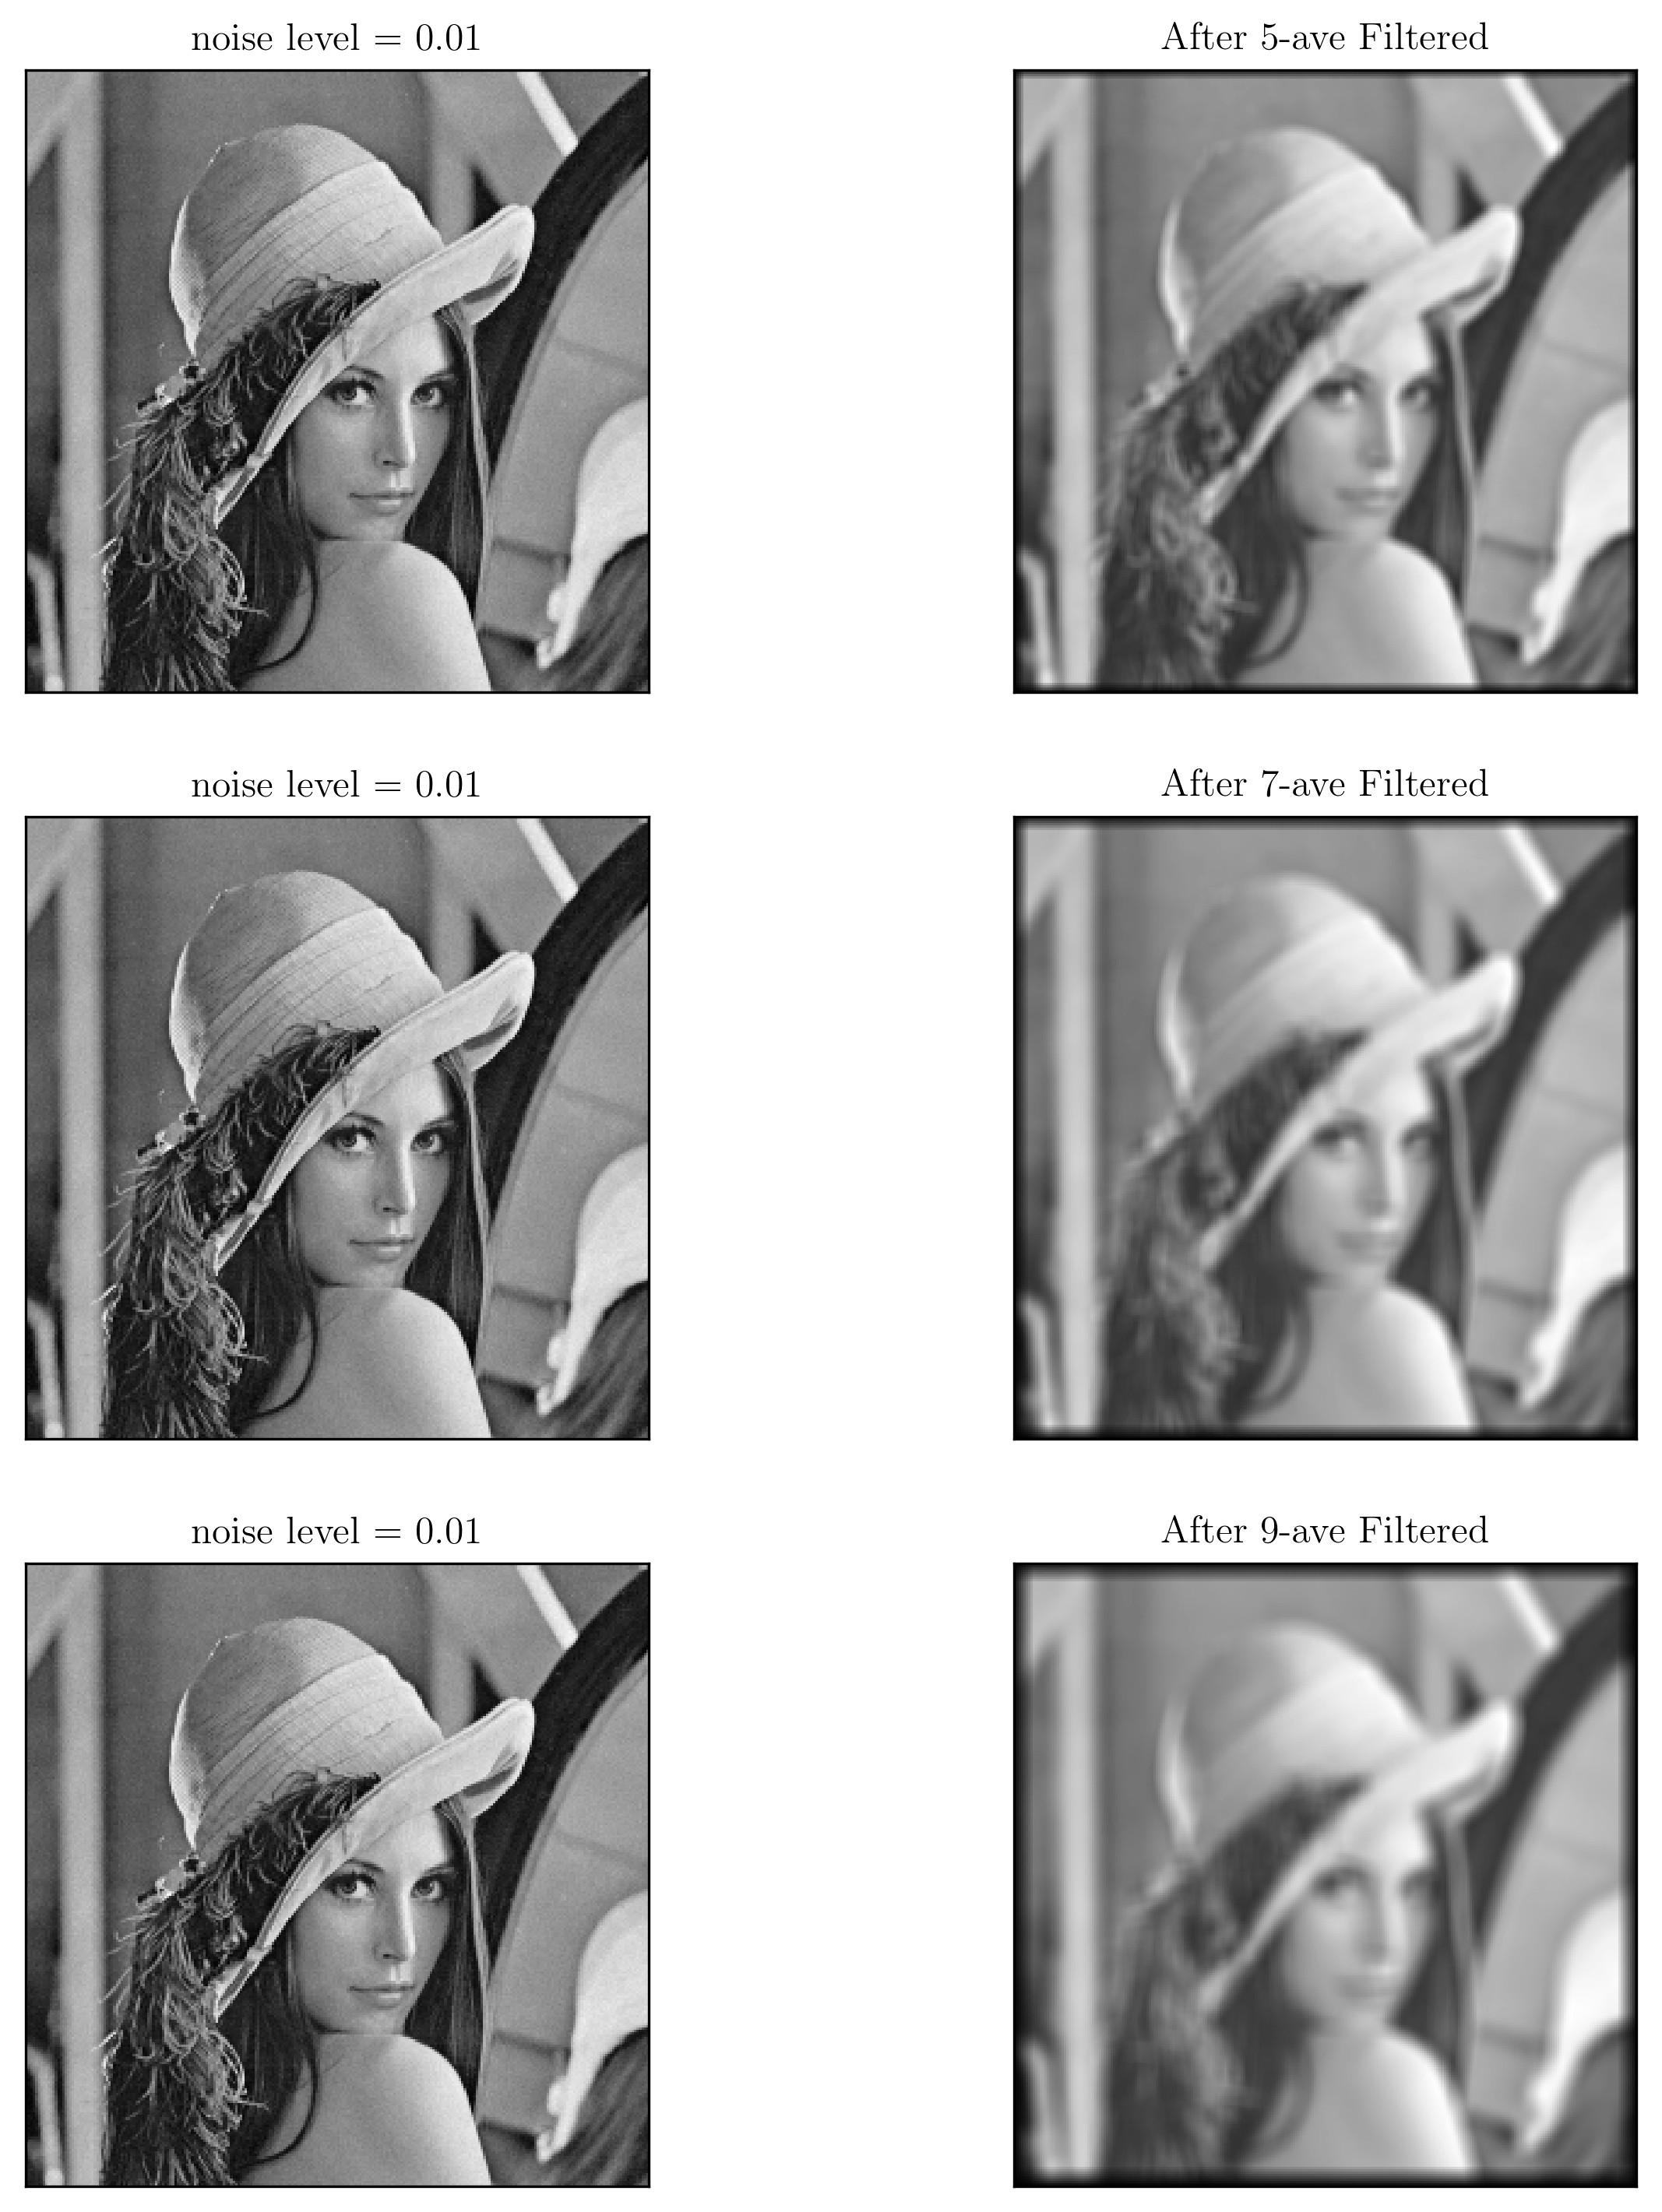

In [13]:
plt.figure(dpi=300,figsize=[10,12])
nn = 0
for Id,iaf in enumerate(ave_filter):
    plt.subplot(321+Id*2)
    plt.imshow(lenna_gray_n[nn],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('noise level = '+lgn_title[nn])
    plt.subplot(322+Id*2)
    plt.imshow(conv2D(lenna_gray_n[nn],iaf),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('After '+ave_title[Id]+'-ave Filtered')

Average filters showed smoothing effect. The effect goes stronger as `n` increasing, but results in more severe blurring at the same time.

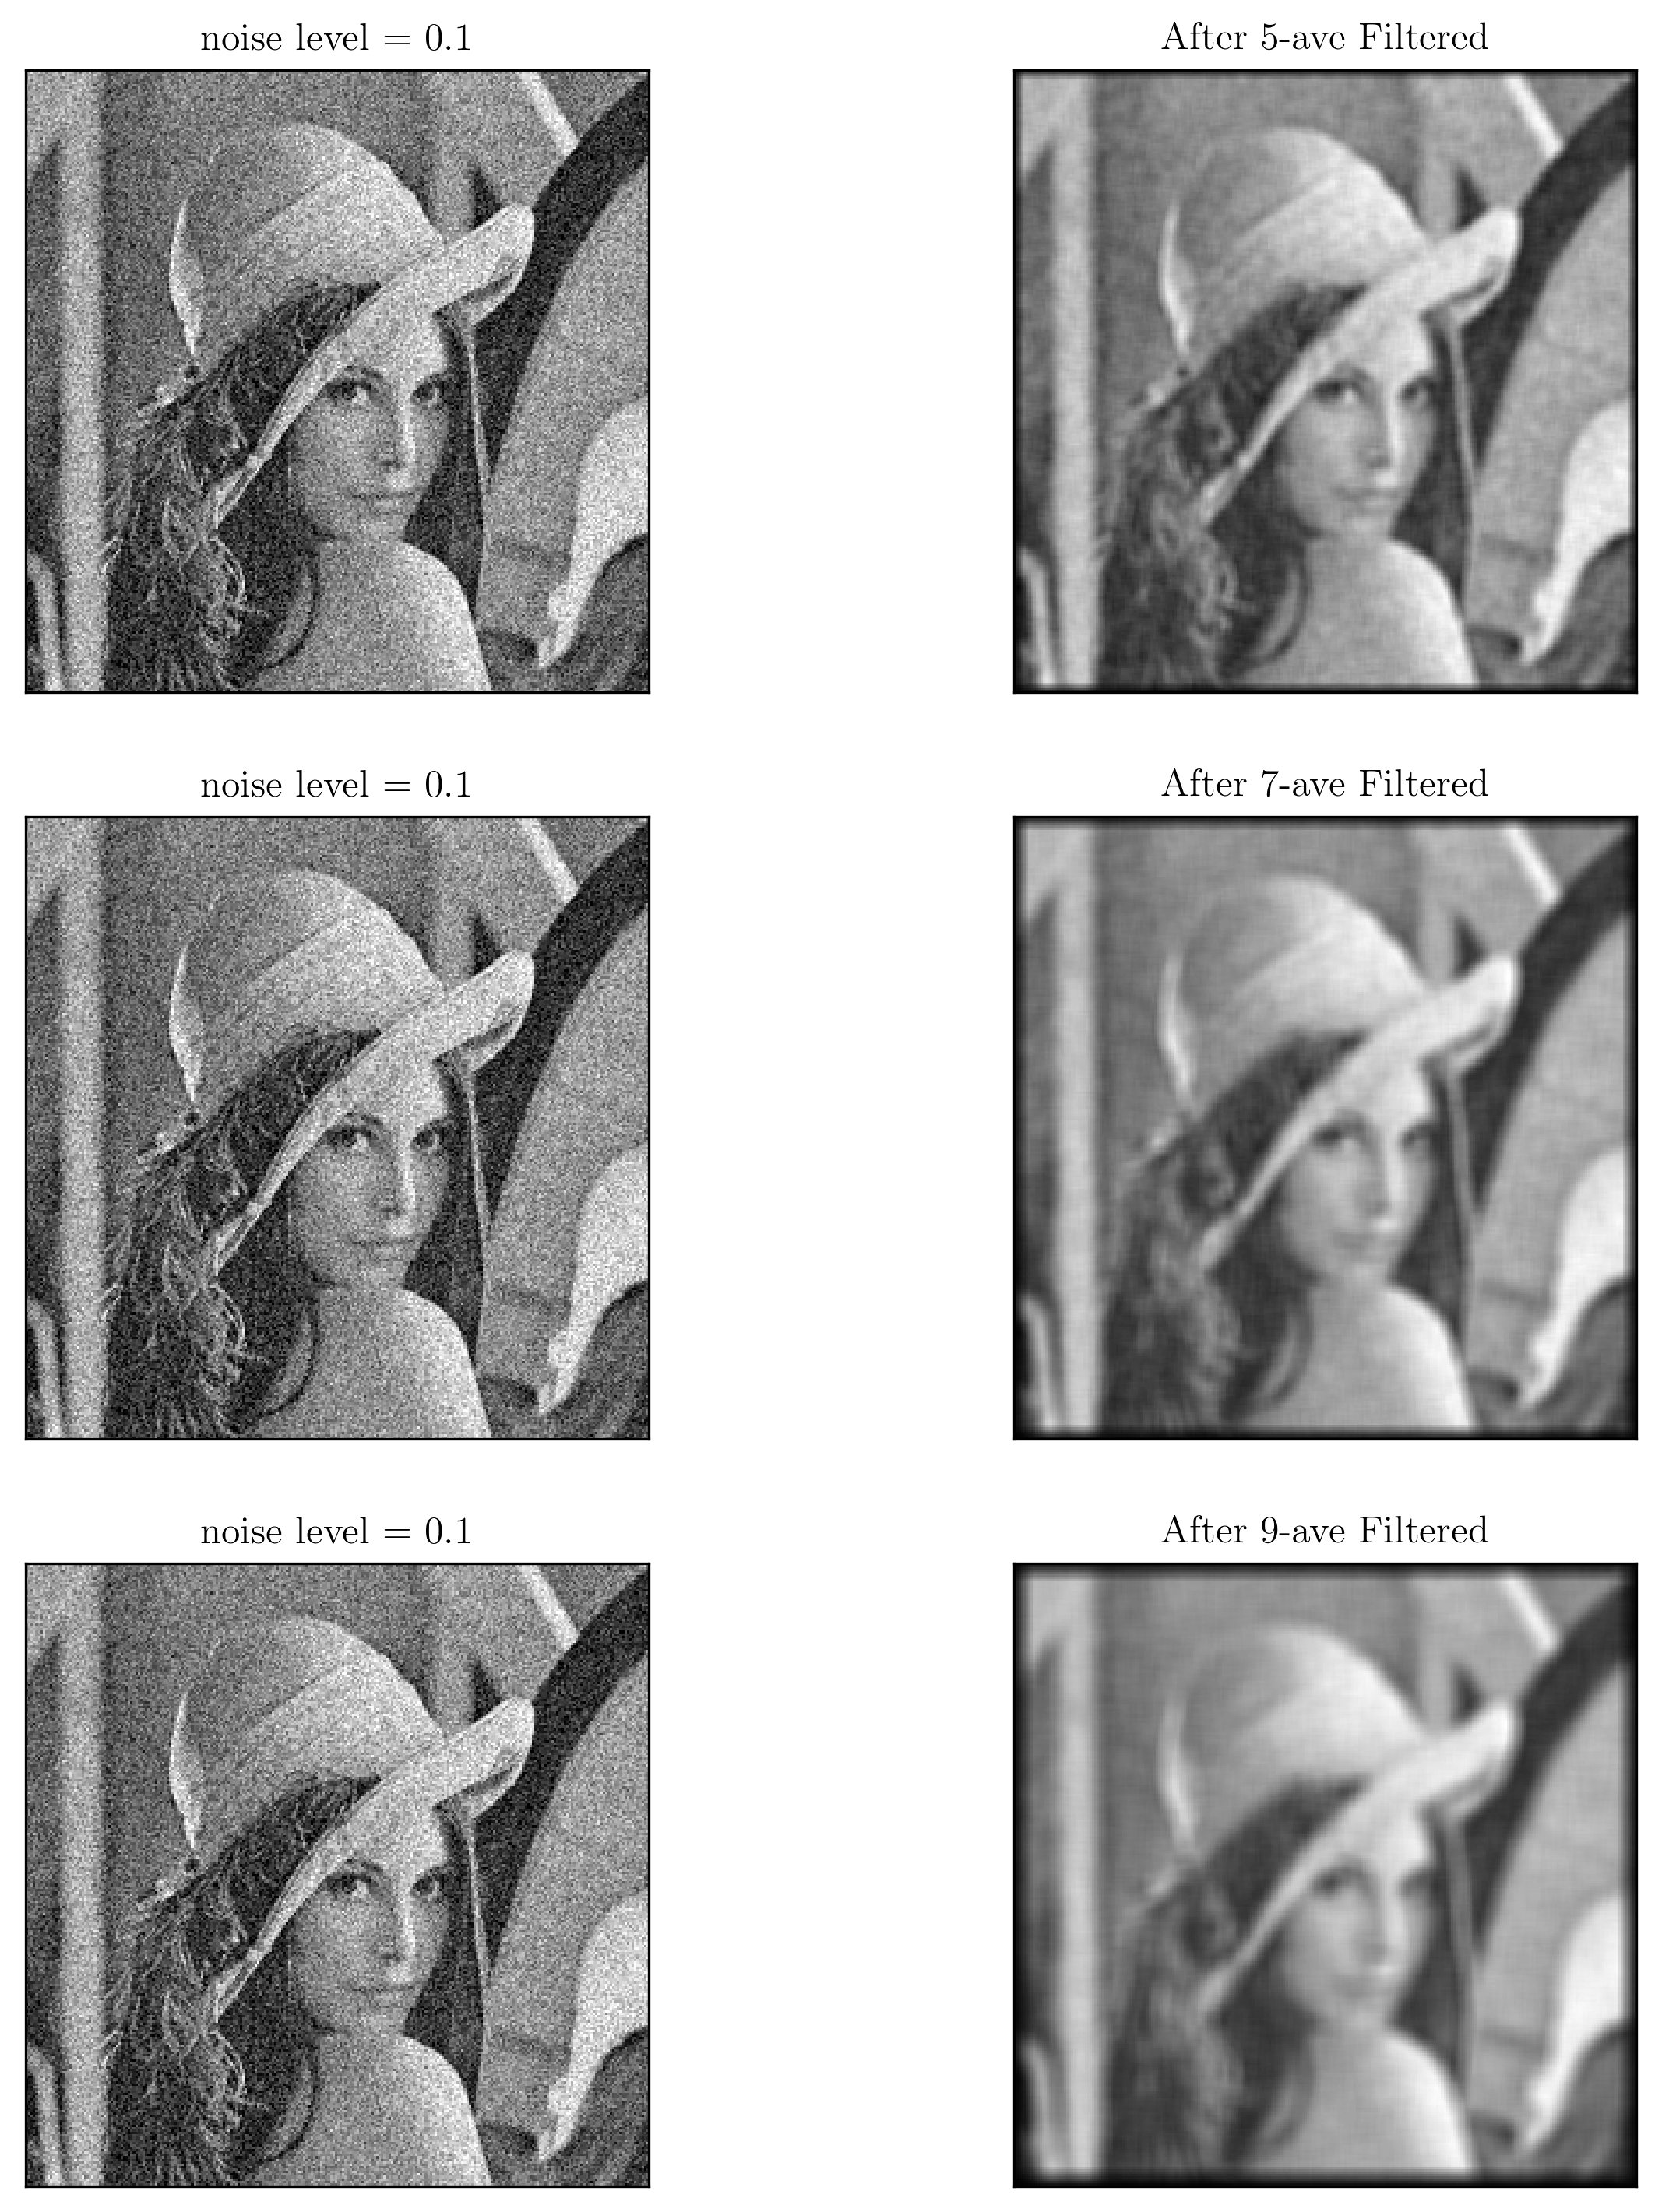

In [14]:
plt.figure(dpi=300,figsize=[10,12])
nn = 1
for Id,iaf in enumerate(ave_filter):
    plt.subplot(321+Id*2)
    plt.imshow(lenna_gray_n[nn],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('noise level = '+lgn_title[nn])
    plt.subplot(322+Id*2)
    plt.imshow(conv2D(lenna_gray_n[nn],iaf),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('After '+ave_title[Id]+'-ave Filtered')

Faced with severe noise, average filter unmaskes its deficiency.

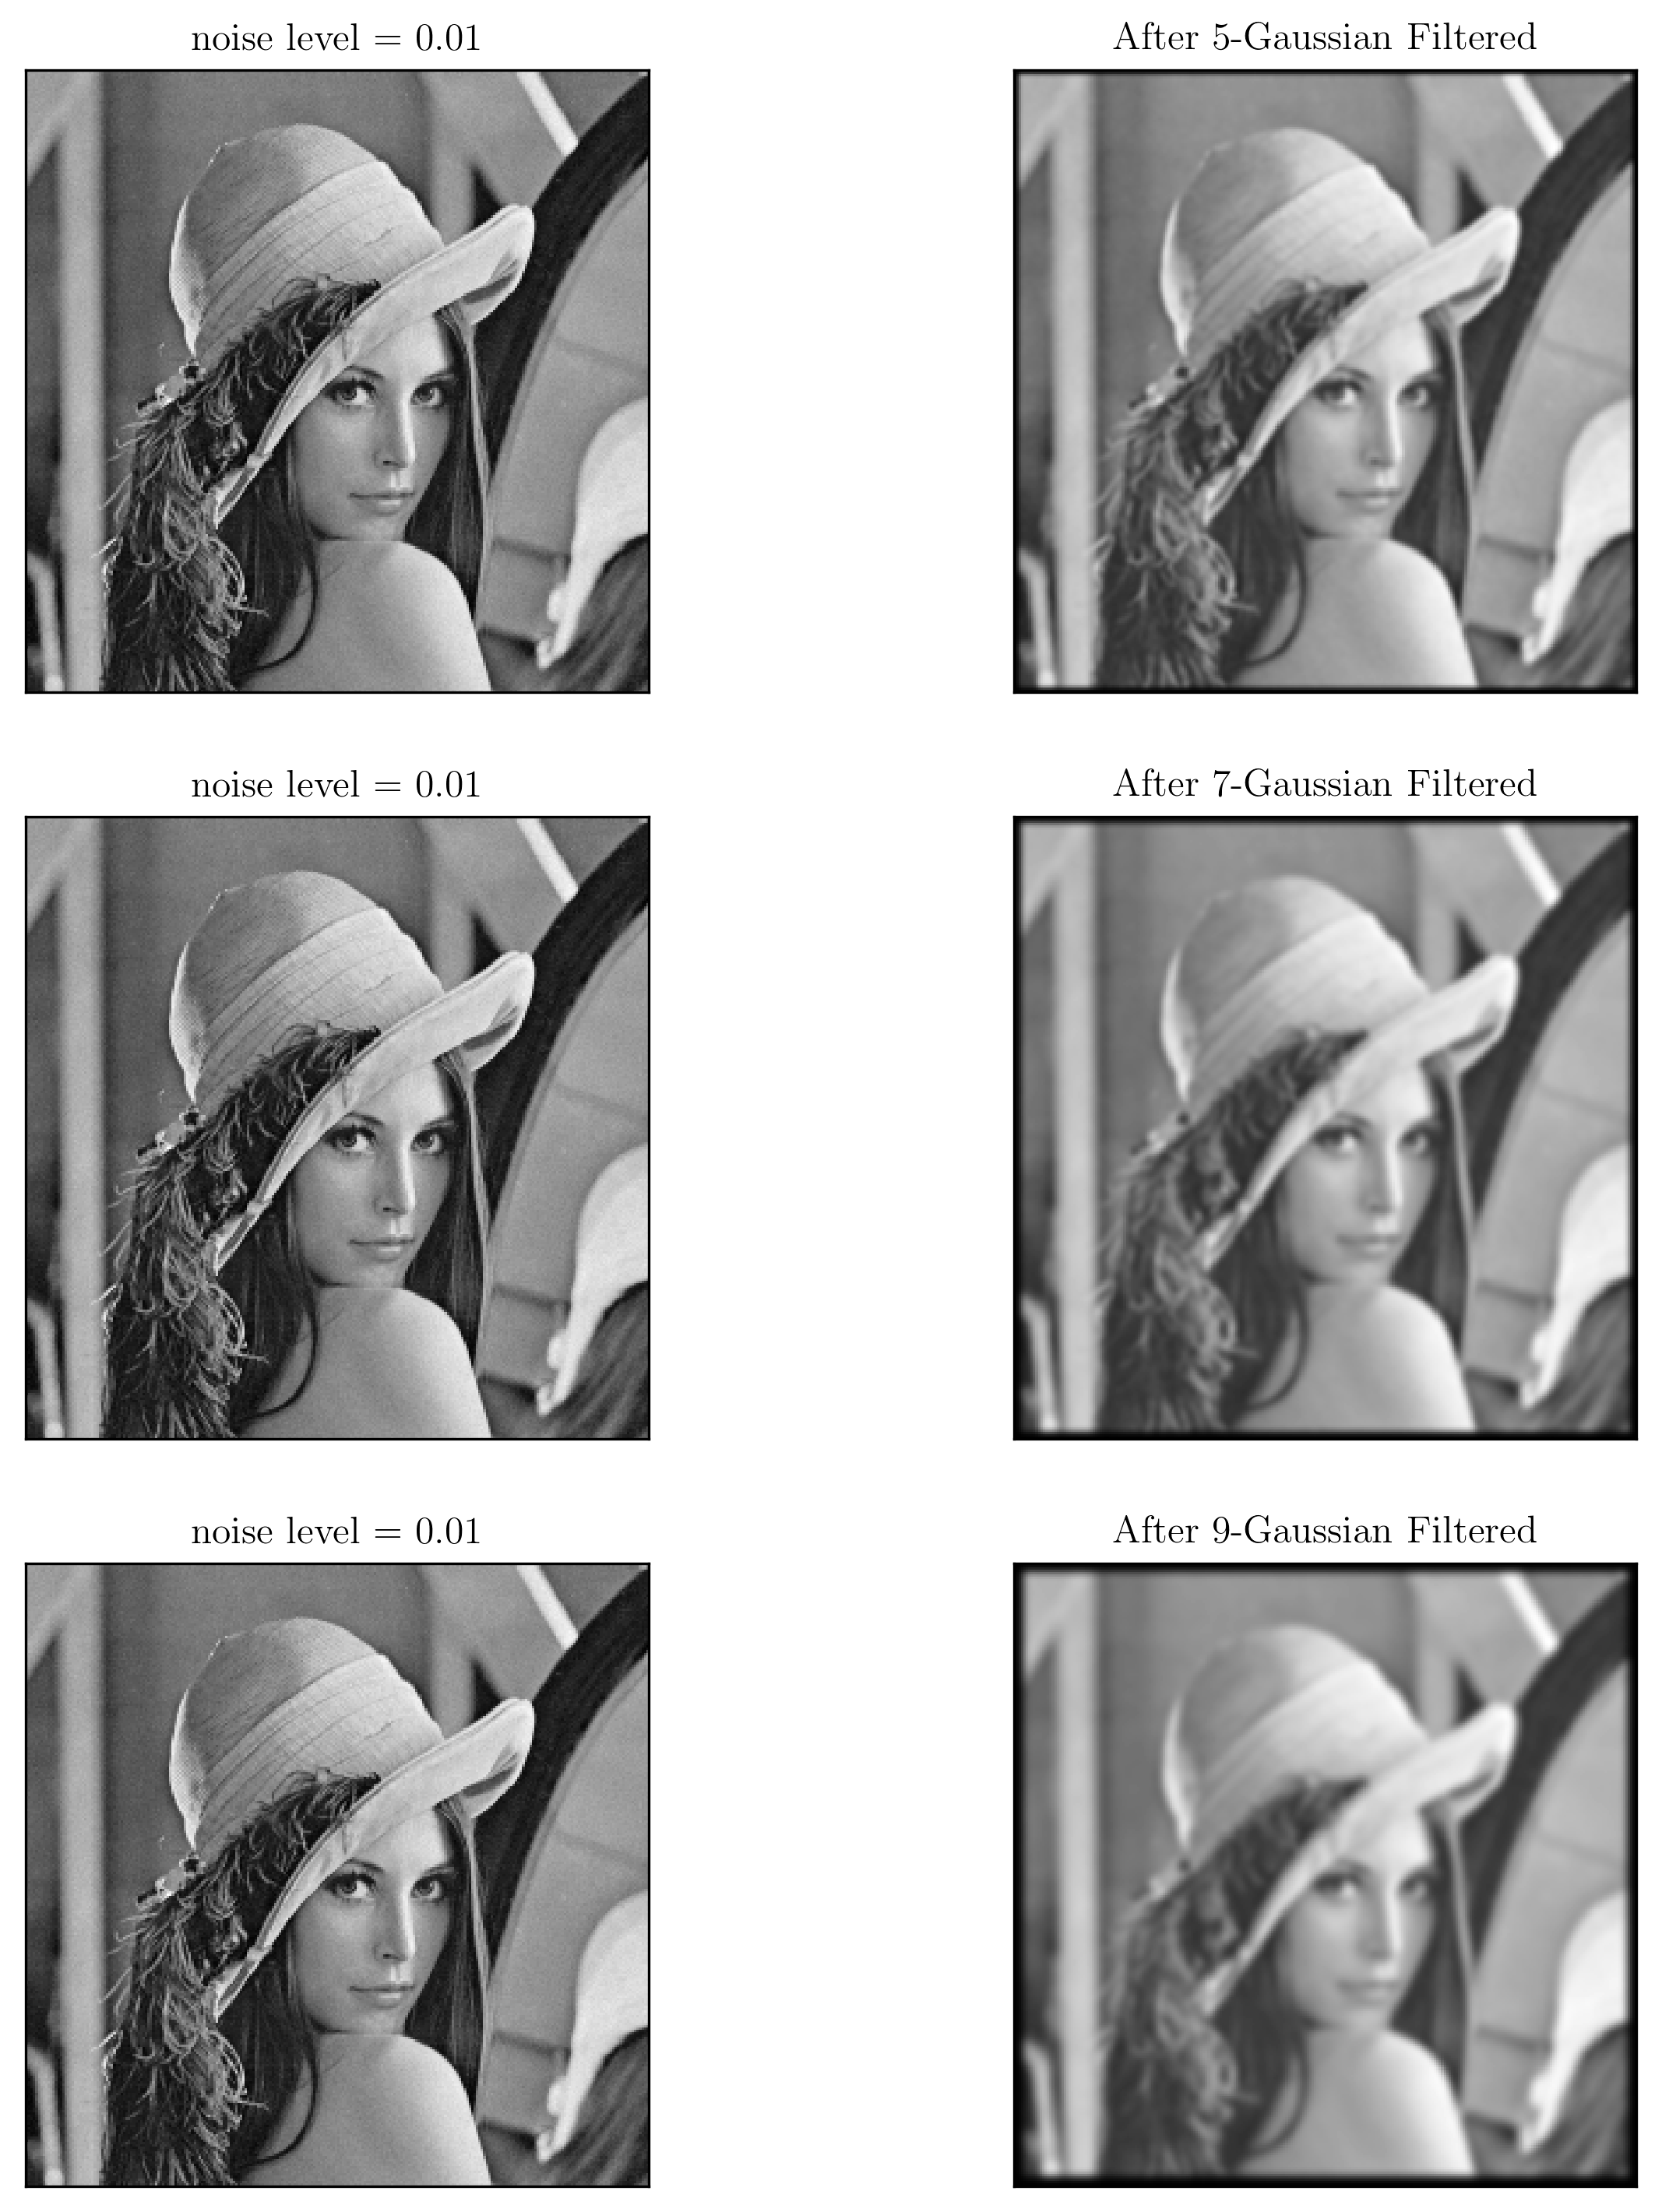

In [15]:
plt.figure(dpi=300,figsize=[10,12])
nn = 0
for Id,igf in enumerate(gau_filter):
    plt.subplot(321+Id*2)
    plt.imshow(lenna_gray_n[nn],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('noise level = '+lgn_title[nn])
    plt.subplot(322+Id*2)
    plt.imshow(conv2D(lenna_gray_n[nn],igf),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('After '+gau_title[Id]+'-Gaussian Filtered')

Gaussian filter works more well than average filter when dealing with gaussian noise, and brings less blurring.

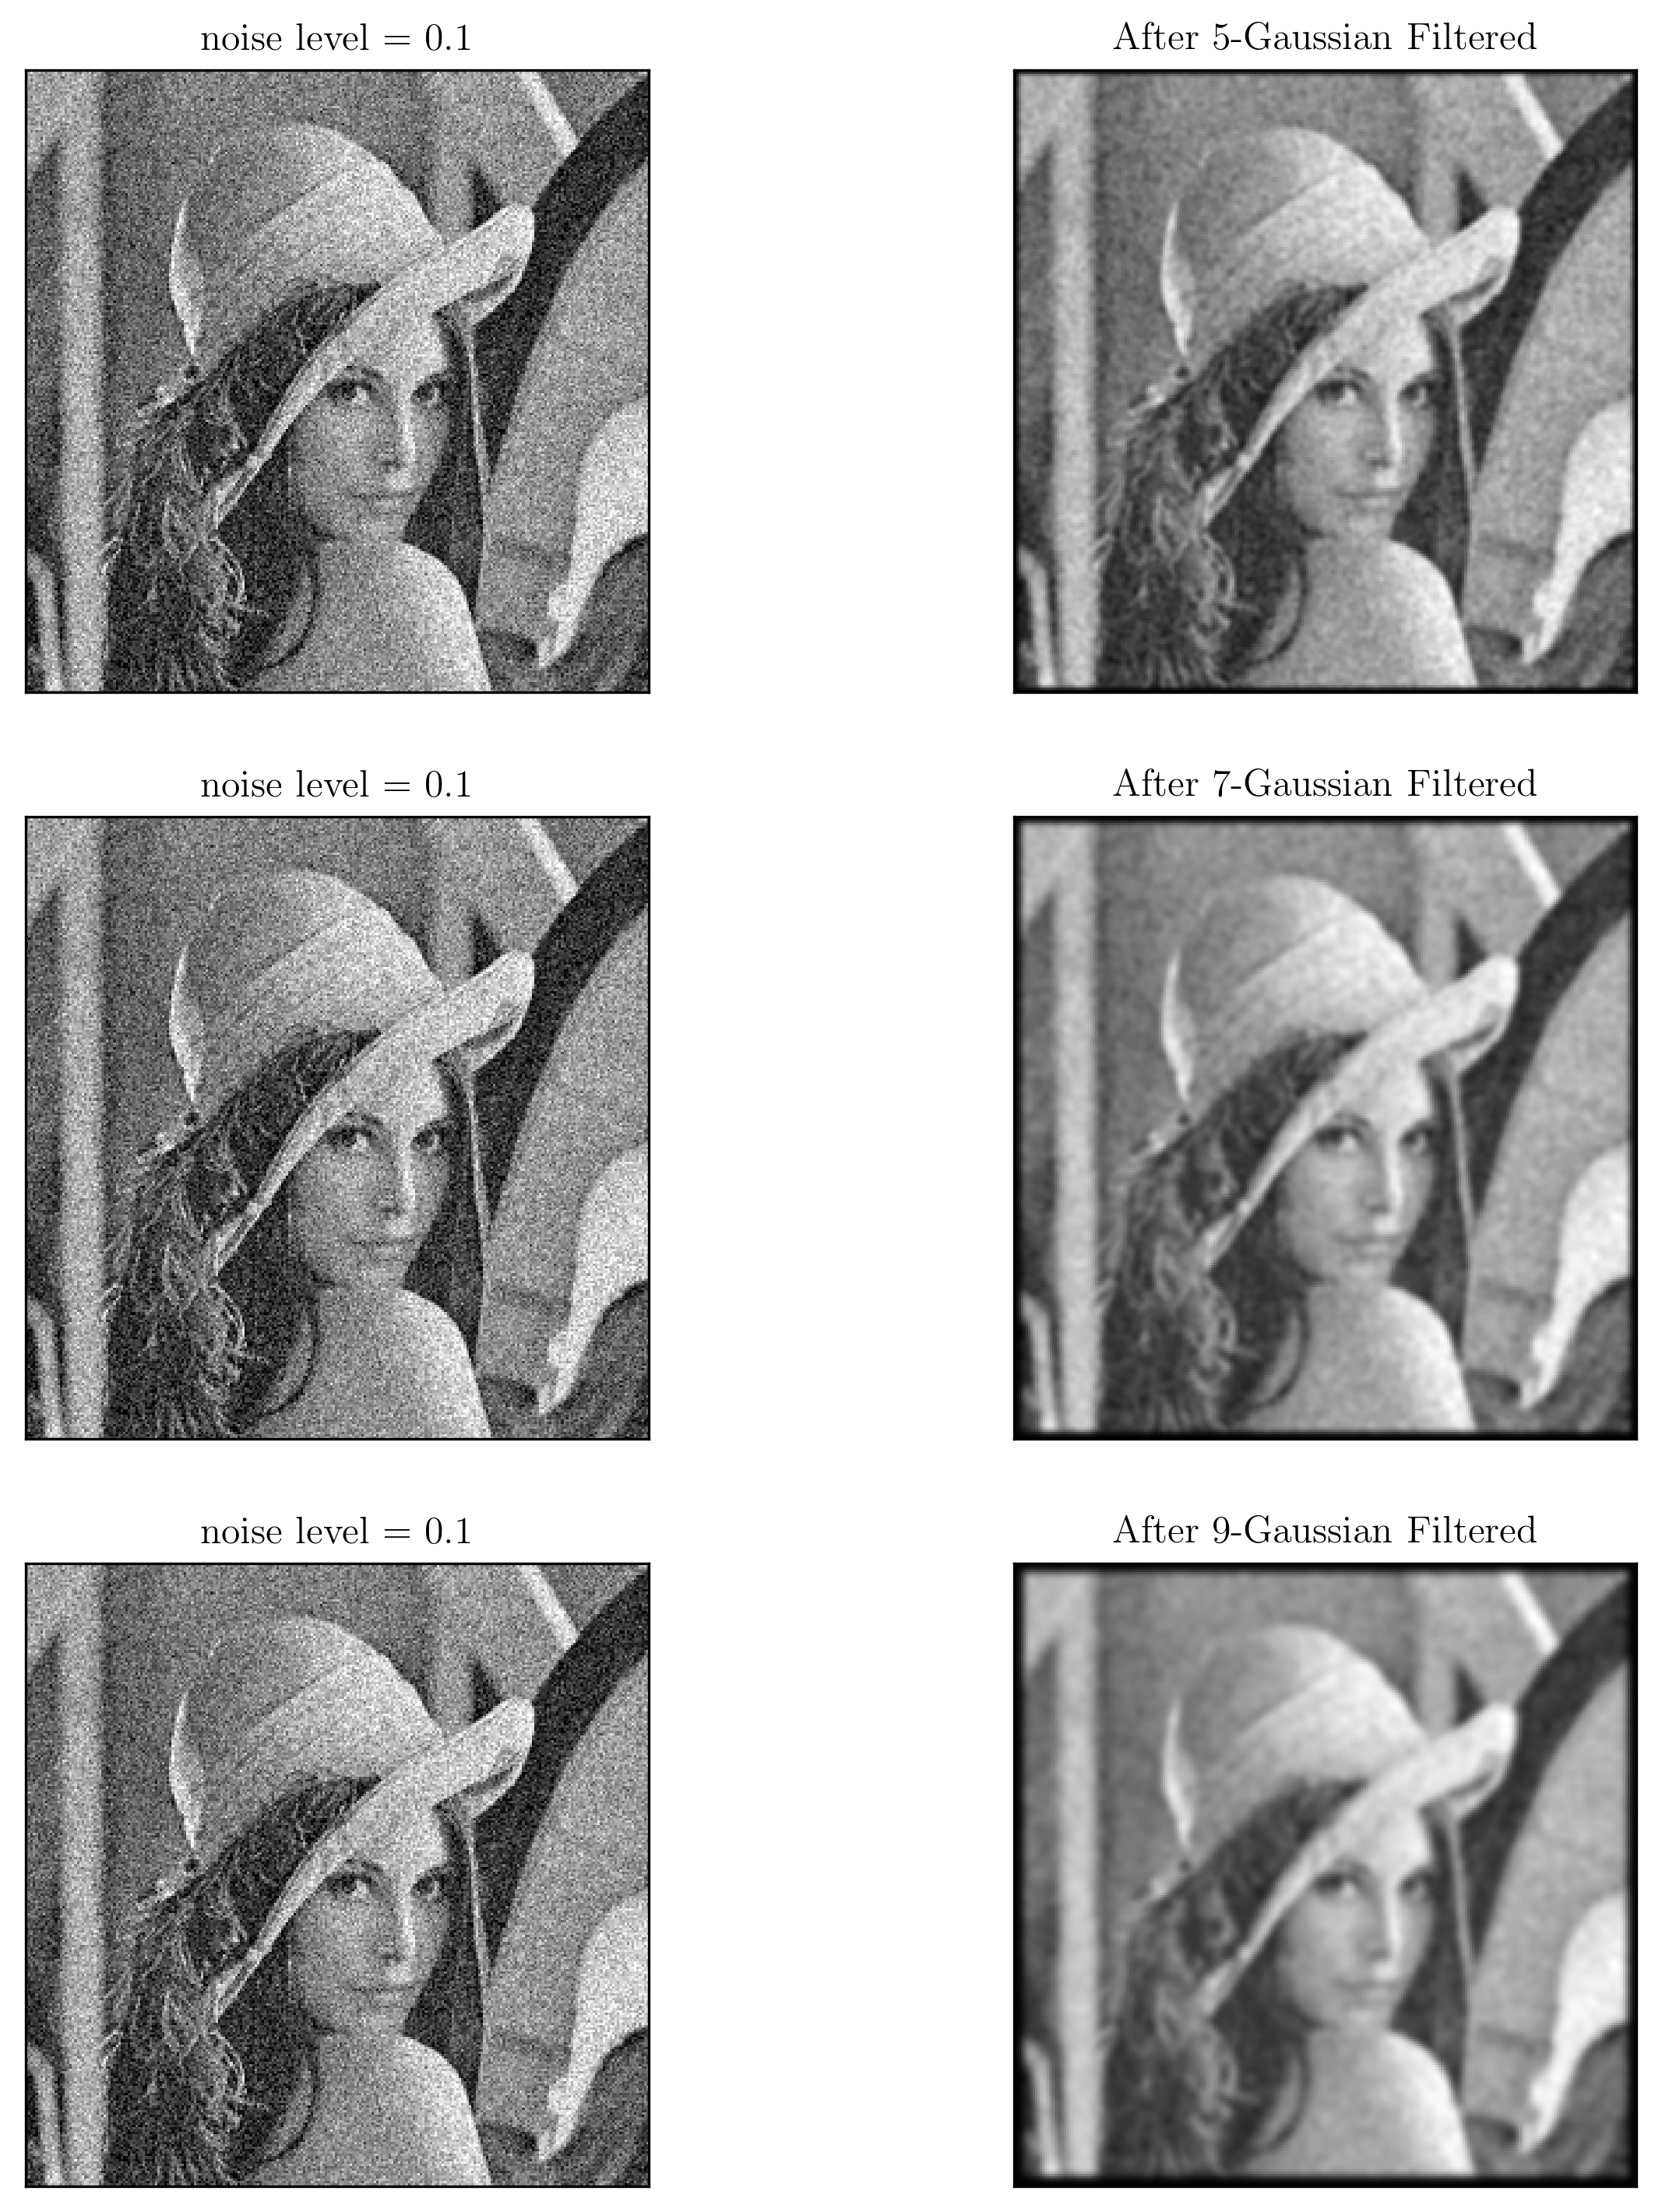

In [16]:
plt.figure(dpi=300,figsize=[10,12])
nn = 1
for Id,igf in enumerate(gau_filter):
    plt.subplot(321+Id*2)
    plt.imshow(lenna_gray_n[nn],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('noise level = '+lgn_title[nn])
    plt.subplot(322+Id*2)
    plt.imshow(conv2D(lenna_gray_n[nn],igf),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('After '+gau_title[Id]+'-Gaussian Filtered')

Even dealing with severe noise, gaussian filters still works well.